In [106]:
#Método para realizar o Boruta, e ao final, montar um DataFrame com a ordem selecionada pelo boruta

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder

def boruta_feature_order(data_path, target_column):
    # Carregar os dados do CSV
    D = pd.read_csv(data_path)
    variables = D.columns
    print(f'Lista de variáveis: {variables}')

    # Print para verificar os dados antes do processamento
    print("Dados antes do processamento:")
    print(D)
    tipo_antes = (type(D[target_column][0]))
    print(f'Tipo dos dados antes do processamento: {tipo_antes}')
    

    # Mapear os valores nominais para números inteiros únicos
    D_encoded = D.apply(LabelEncoder().fit_transform)
    # Print para verificar os dados após o processamento
    print("Dados após o processamento:")
    print(D_encoded)
    tipo_depois = (type(D_encoded[target_column][0]))
    print(f'Tipo dos dados após o processamento (inteiros): {tipo_depois}')

    # Separar os dados em características (X) e alvo (y)
    X = D_encoded.drop(columns=[target_column])
    y = D_encoded[target_column]

    # Inicializar um classificador Random Forest
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    # Inicializar o Boruta
    boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

    # Ajustar o Boruta aos dados
    boruta_selector.fit(X.values, y.values)
    print("Boruta inicializado com sucesso")

    # Obter as características selecionadas
    print("Variáveis na ordem inicial")
    print(variables)
    
    selected_features = X.columns[boruta_selector.support_]
    print("Features selecionadas")
    print(selected_features)
    # Obter as características não selecionadas
    unselected_features = X.columns[~boruta_selector.support_]
    print("Features não selecionadas")
    print(unselected_features)

    # Combinar características selecionadas e não selecionadas, ordenando-as pela ordem de ranking do Boruta
    all_features = [target_column] + list(selected_features) + list(unselected_features)
    print("Todas as features, incluindo a target: ")
    print(all_features)

    # Reorganizar o DataFrame original de acordo com a ordem das características selecionadas pelo Boruta
    df_reordered = D[all_features]
    
    # Salvar o DataFrame reordenado no formato CSV
    df_reordered.to_csv("data_reordered.csv", index=False)

    print("DataFrame reordenado salvo como data_reordered.csv")
    print("DataFrame criado na ordem das features selecionadas pelo Boruta")
    print(df_reordered)
    
    return all_features

# Caminho para o arquivo CSV e o nome da coluna alvo
data_path = "teste.csv"
target_column = "contact-lenses"

# Obter todas as características, incluindo a coluna alvo
all_features= boruta_feature_order(data_path, target_column)
print("Features em ordem")
print(all_features)

Lista de variáveis: Index(['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate',
       'contact-lenses'],
      dtype='object')
Dados antes do processamento:
               age spectacle-prescrip astigmatism tear-prod-rate  \
0            young              myope          no        reduced   
1            young              myope          no         normal   
2            young              myope         yes        reduced   
3            young              myope         yes         normal   
4            young       hypermetrope          no        reduced   
5            young       hypermetrope          no         normal   
6            young       hypermetrope         yes        reduced   
7            young       hypermetrope         yes         normal   
8   pre-presbyopic              myope          no        reduced   
9   pre-presbyopic              myope          no         normal   
10  pre-presbyopic              myope         yes        reduced   
11  pre-presbyopi

In [108]:
import pandas as pd
import sys
from pgmpy.estimators import K2Score
from sklearn.preprocessing import LabelEncoder
import time
import networkx as nx
import matplotlib.pyplot as plt

def load_data(DATA_CSV):
    D = pd.read_csv('data_reordered.csv')
    #D = D.apply(LabelEncoder().fit_transform)

    V = D.columns
    N = len(D.index)
    V_CARD = {v: len(D[v].unique()) for v in V}


    print(f'ARQUIVO: {D}')
    print(f'VARIÁVEIS: {V}')
    print(f'NÚMERO DE AMOSTRAS: {N}')
    print(f'MAPEAMENTO DAS VARIÁVEIS COM NÚMEROS DE VALORES ÚNICOS: {V_CARD}')
    return D, V, N, V_CARD

'''def predecessors(x, pa, ordering):
    pred = []
    x_idx = ordering.index(x)
    for y in ordering[:x_idx]:
        if y not in pa:
            pred.append(y)
    return pred

def K2_algorithm(ordering, max_parents, D):
    k2sc = K2Score(D).local_score
    PI = {v: [] for v in V}
    total_score = 0  # Inicializar o score total

    for x in V[1:]:
        proceed = True
        old_sc = k2sc(x, PI[x])
        while proceed and len(PI[x]) < max_parents[x]:
            proceed = False
            z, new_sc = None, None
            pred = predecessors(x, PI[x], ordering)
            if pred != []:
                z, new_sc = max([(y, k2sc(x, PI[x] + [y])) for y in pred], key=lambda t: t[1])
                if new_sc > old_sc:
                    old_sc = new_sc
                    PI[x].append(z)
                    proceed = True
        # Acumular o score total
        total_score += old_sc

    print("Score Total:", total_score)  # Imprimir o score total
    print("Rede: ", PI)
    #Guardar o PI no arquivo, para imprimir o desenho num arquivo para realizar as comparações
    #Deve ter uma função para realizar isso
    #Pesquisar: Comparar redes bayesianas com pgmpy ou bnlearn

    # Criar um grafo direcionado
    G = nx.DiGraph()
    for node, parents in PI.items():
        for parent in parents:
            G.add_edge(parent, node)

    # Desenhar o grafo
    plt.figure(figsize=(8, 5))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=12, font_weight="bold", arrowsize=20)
    plt.title(f"Rede Aprendida com a target {target_column} e com Score: {total_score}")
    plt.show()

    return PI, total_score'''


if __name__ == '__main__':
    DATA_CSV = sys.argv[1]
    #k = sys.argv[2]

    D, V, N, V_CARD = load_data(DATA_CSV)
    #Para passar as variáveis em ordem, selecionadas pelo Boruta, passamos como parâmetro a all_features
    print('Numero de variáveiss: ', len(V))
    print('Numero de amostras: ', N)
    print('Lista de variáveis de acordo com o Boruta: ', V)

    start_time = time.time()
    

    parents = int(len(V)) / 5
    max_parents = {v: parents for v in V}
    ordering = [v for v in V]

    #PI = K2_algorithm(ordering, max_parents, D)

    final_time = time.time() - start_time

    print(f'Tempo gasto: {final_time}')




ARQUIVO:    contact-lenses astigmatism tear-prod-rate             age  \
0            none          no        reduced           young   
1            soft          no         normal           young   
2            none         yes        reduced           young   
3            hard         yes         normal           young   
4            none          no        reduced           young   
5            soft          no         normal           young   
6            none         yes        reduced           young   
7            hard         yes         normal           young   
8            none          no        reduced  pre-presbyopic   
9            soft          no         normal  pre-presbyopic   
10           none         yes        reduced  pre-presbyopic   
11           hard         yes         normal  pre-presbyopic   
12           none          no        reduced  pre-presbyopic   
13           soft          no         normal  pre-presbyopic   
14           none         yes  

   contact-lenses astigmatism tear-prod-rate             age  \
0            none          no        reduced           young   
1            soft          no         normal           young   
2            none         yes        reduced           young   
3            hard         yes         normal           young   
4            none          no        reduced           young   
5            soft          no         normal           young   
6            none         yes        reduced           young   
7            hard         yes         normal           young   
8            none          no        reduced  pre-presbyopic   
9            soft          no         normal  pre-presbyopic   
10           none         yes        reduced  pre-presbyopic   
11           hard         yes         normal  pre-presbyopic   
12           none          no        reduced  pre-presbyopic   
13           soft          no         normal  pre-presbyopic   
14           none         yes        red

  0%|          | 0/1000000 [00:00<?, ?it/s]

[datazets] >WARNING> BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.


[('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
+----------------------+----------+
| contact-lenses(hard) | 0.195402 |
+----------------------+----------+
| contact-lenses(none) | 0.574713 |
+----------------------+----------+
| contact-lenses(soft) | 0.229885 |
+----------------------+----------+
+-------------------------+-----+----------------------+
| contact-lenses          | ... | contact-lenses(soft) |
+-------------------------+-----+----------------------+
| tear-prod-rate(normal)  | ... | 0.875                |
+-------------------------+-----+----------------------+
| tear-prod-rate(reduced) | ... | 0.12500000000000003  |
+-------------------------+-----+----------------------+
+------------------+-----+----------------------+
| contact-lenses   | ... | contact-lenses(soft) |
+------------------+-----+----------------------+
| astigmatism(no)  | ... | 0.875                |
+------------------+-----+----------------------+
| astigmatism(yes) | ... 

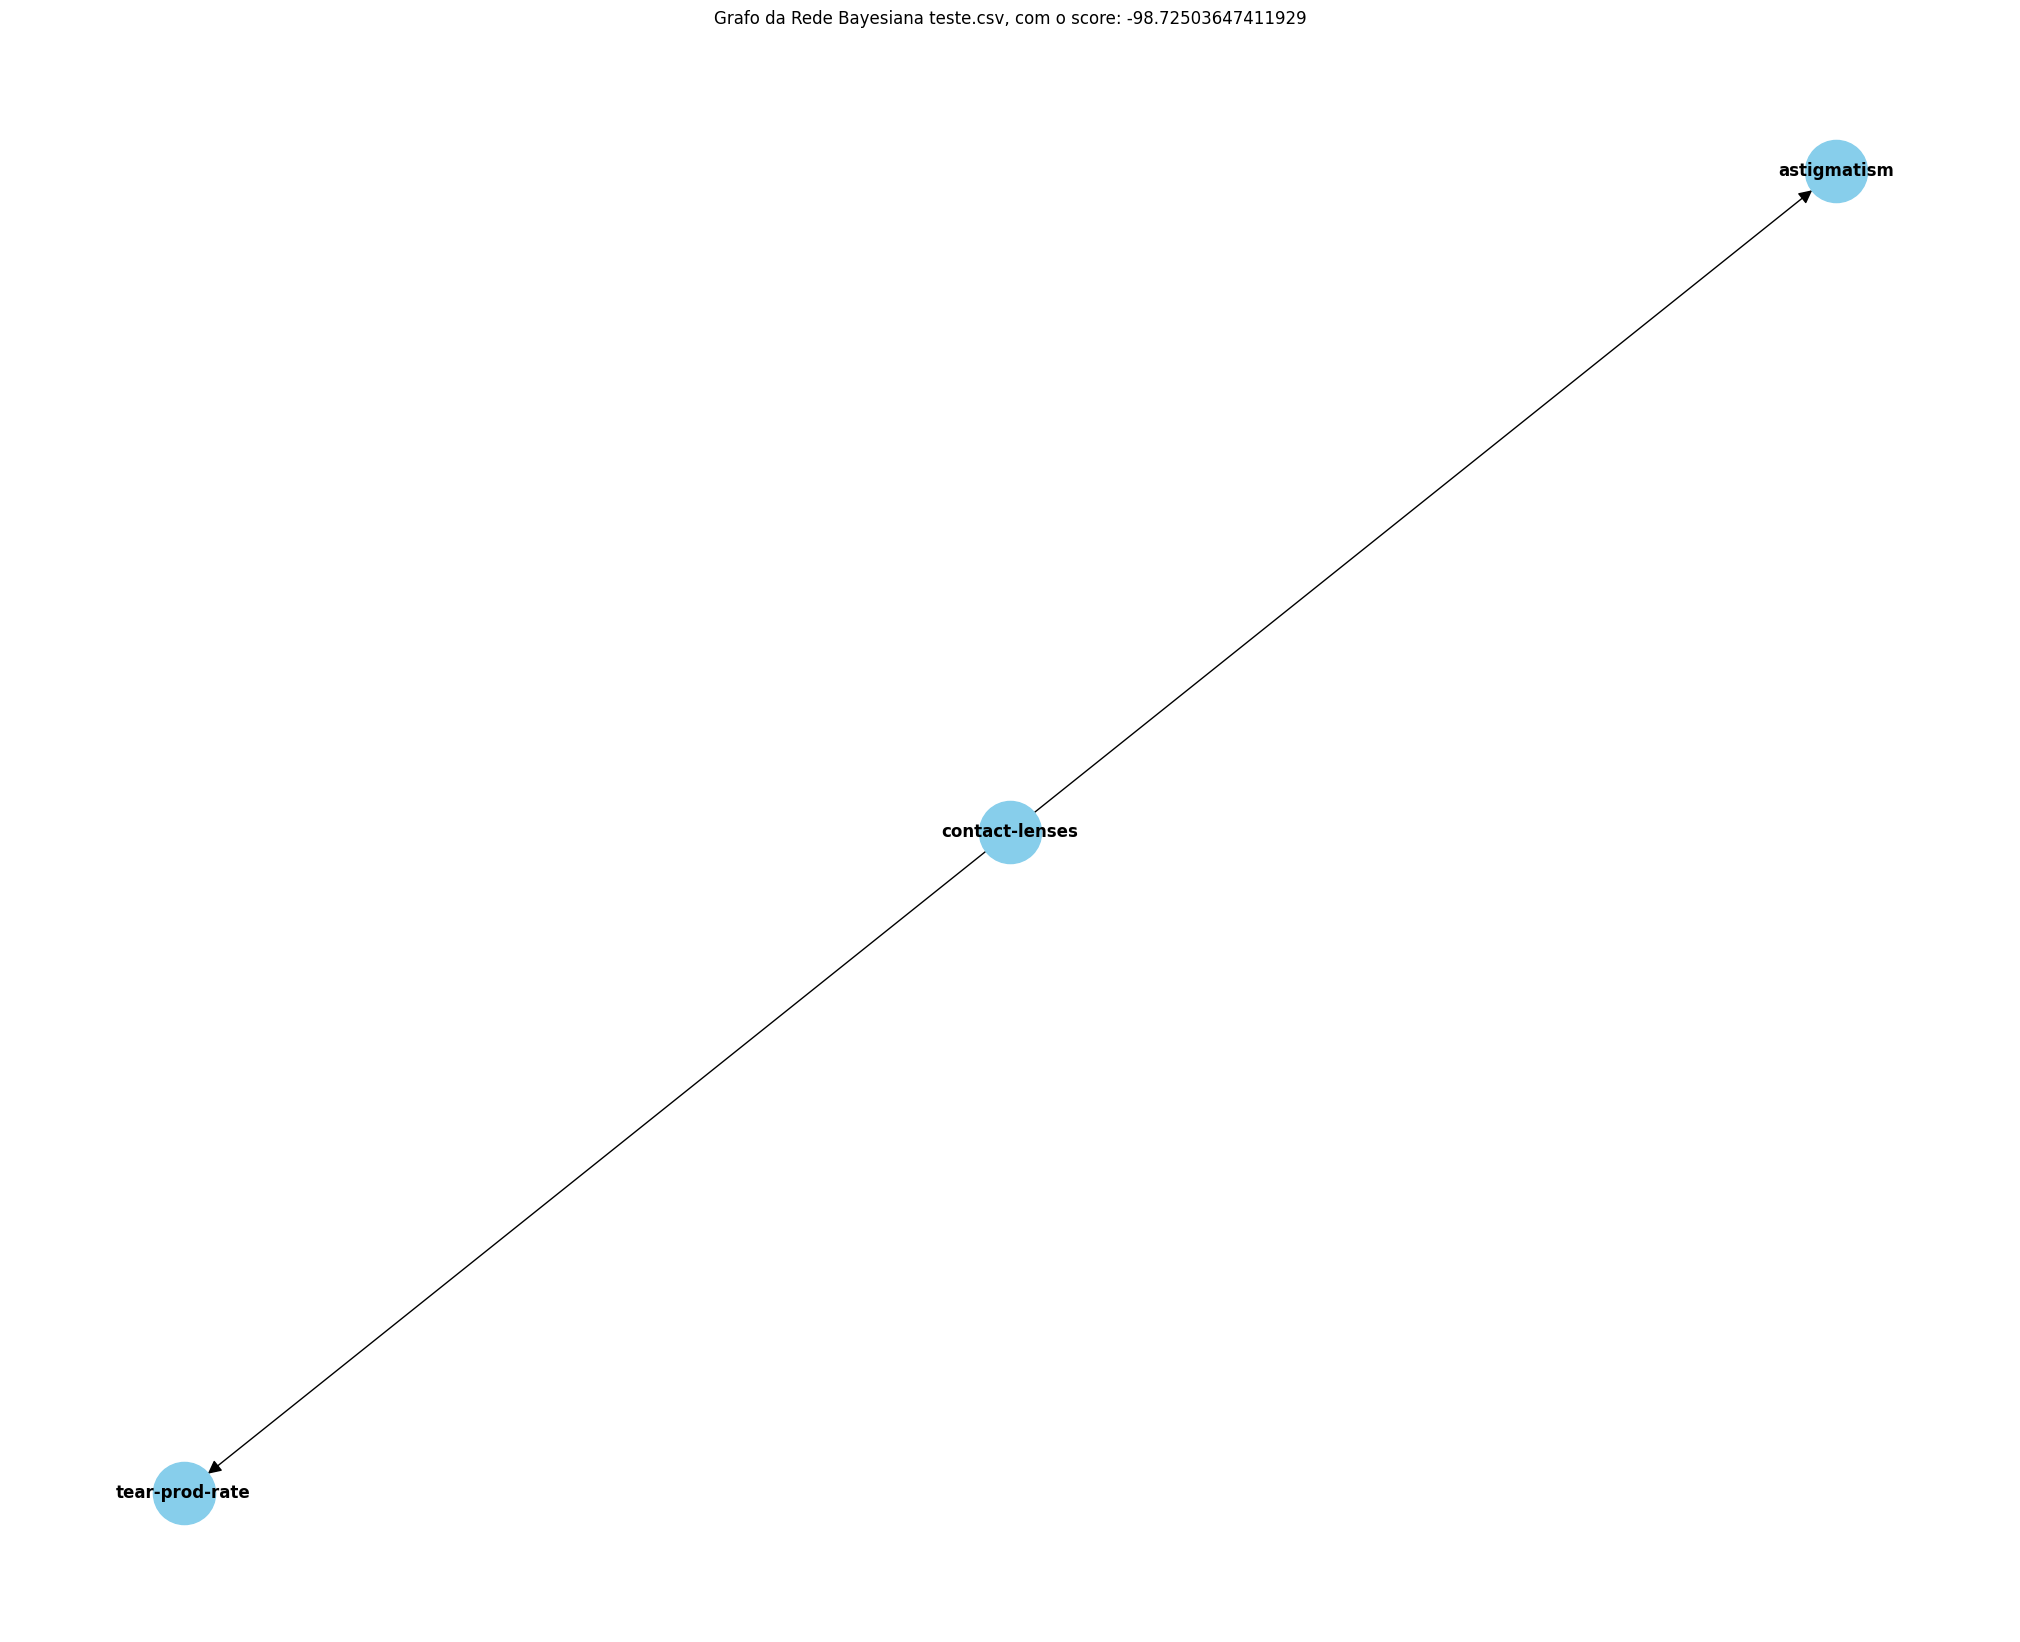

In [109]:
#Método K2 mais correto, que retorna as CPDs

from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, K2Score, BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt

def calcular_k2(D):
    """
    Calcula a pontuação K2 para os dados fornecidos.

    Args:
    - D: DataFrame contendo os dados.

    Returns:
    - k2score: Objeto K2Score contendo a pontuação K2 calculada.
    """
    k2score = K2Score(D)
    return k2score

def estimar_modelo(D, scoring_method):
    """
    Estima a estrutura do modelo usando o método K2.

    Args:
    - D: DataFrame contendo os dados.
    - scoring_method: Objeto de pontuação a ser usado para estimar a estrutura.

    Returns:
    - best_model: Modelo BayesianModel estimado.
    """
    estimator_k2 = HillClimbSearch(D)
    best_model = estimator_k2.estimate(scoring_method=scoring_method)
    return best_model

def tabular_cpd(best_model, D):
    """
    Estima as CPDs para o modelo usando o estimador bayesiano.

    Args:
    - best_model: Modelo BayesianModel estimado.
    - D: DataFrame contendo os dados.

    Returns:
    - cpds: Lista de CPDs estimadas.
    """
    bayesian_network = BayesianModel(best_model.edges())
    estimator = BayesianEstimator(bayesian_network, D)
    cpds = estimator.get_parameters()
    return cpds

def desenhar_grafo(best_model, k2_score):
    """
    Desenha o grafo da Rede Bayesiana.

    Args:
    - best_model: Modelo BayesianModel estimado.
    - k2_score: Valor do score K2 calculado.
    """
    graph = nx.DiGraph()
    graph.add_edges_from(best_model.edges())
    plt.figure(figsize=(20, 16))
    nx.draw(graph, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
    plt.title(f'Grafo da Rede Bayesiana {data_path}, com o score: {k2_score}')
    plt.show()

# Dados já reordenados pelo Boruta, e suas propriedades
print(D)

V = D.columns
N = len(D.index)

print(f'VARIÁVEIS: {V}')
print(f'NÚMERO DE AMOSTRAS: {N}')

# Calcula a pontuação K2
k2score = calcular_k2(D)

# Estima a estrutura do modelo com o K2
best_model = estimar_modelo(D, k2score)

# Valor do Score gerado pelo K2
k2_score = k2score.score(best_model)

# Exibe a estrutura do modelo
structure = (best_model.edges())
print(structure)

# Estima as CPDs
cpds = tabular_cpd(best_model, D)

# Exibe as CPDs estimadas
for cpd in cpds:
    print(cpd)

# Desenha o grafo
desenhar_grafo(best_model, k2_score)


In [112]:
from pgmpy.readwrite import XMLBIFWriter

# Inicialize o Modelo Bayesian
modelo_completo = BayesianModel()

# Definindo a estrutura do modelo
modelo_completo.add_edges_from(structure)

# Adicionando as CPDs ao Modelo
for cpd in cpds:
    modelo_completo.add_cpds(cpd)

# Verifique a consistência do modelo
assert modelo_completo.check_model()

# Verificar a Estrutura do Modelo
print("Estrutura do Modelo:")
print(modelo_completo.edges())

# Verificar as CPDs
print("\nCPDs do Modelo:")
for node in modelo_completo.nodes():
    print(f"CPD para o nó {node}:")
    print(modelo_completo.get_cpds(node))

# Verificar a Consistência do Modelo
print("\nVerificação de Consistência do Modelo:")
print(modelo_completo.check_model())

#Fazendo o formato XMLBIF
writer = XMLBIFWriter(modelo_completo)

# Especifique o nome do arquivo para salvar o modelo
nome_arquivo = "teste.xml"

# Escreva o modelo no arquivo .xmlbif
writer.write_xmlbif(nome_arquivo)



[datazets] >WARNING> BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.


Estrutura do Modelo:
[('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]

CPDs do Modelo:
CPD para o nó contact-lenses:
+----------------------+----------+
| contact-lenses(hard) | 0.195402 |
+----------------------+----------+
| contact-lenses(none) | 0.574713 |
+----------------------+----------+
| contact-lenses(soft) | 0.229885 |
+----------------------+----------+
CPD para o nó tear-prod-rate:
+-------------------------+-----+----------------------+
| contact-lenses          | ... | contact-lenses(soft) |
+-------------------------+-----+----------------------+
| tear-prod-rate(normal)  | ... | 0.875                |
+-------------------------+-----+----------------------+
| tear-prod-rate(reduced) | ... | 0.12500000000000003  |
+-------------------------+-----+----------------------+
CPD para o nó astigmatism:
+------------------+-----+----------------------+
| contact-lenses   | ... | contact-lenses(soft) |
+------------------+-----+----------------------+


In [108]:
def exportar_xmlbif(best_model, cpds, nome_arquivo, all_nodes, all_values):
    """
    Exporta o modelo e as CPDs para um arquivo no formato XMLBIF.

    Args:
    - best_model: Modelo BayesianModel estimado.
    - cpds: Lista de CPDs estimadas.
    - nome_arquivo: Nome do arquivo XMLBIF a ser gerado.
    - all_nodes: Todos os nós do dataset, mesmo aqueles que não estão conectados no modelo.
    - all_values: Todos os valores possíveis para cada nó do dataset.
    """
    with open(nome_arquivo, 'w') as f:
        f.write('<?xml version="1.0"?>\n')
        f.write('<!-- DTD for the XMLBIF 0.3 format -->\n')
        f.write('<!DOCTYPE BIF [\n')
        f.write('<!ELEMENT BIF ( NETWORK )*>\n')
        f.write('<!ATTLIST BIF VERSION CDATA #REQUIRED>\n')
        f.write('<!ELEMENT NETWORK ( NAME, ( PROPERTY | VARIABLE | DEFINITION )* )>\n')
        f.write('<!ELEMENT NAME (#PCDATA)>\n')
        f.write('<!ELEMENT VARIABLE ( NAME, ( OUTCOME |  PROPERTY )* ) >\n')
        f.write('<!ATTLIST VARIABLE TYPE (nature|decision|utility) "nature">\n')
        f.write('<!ELEMENT OUTCOME (#PCDATA)>\n')
        f.write('<!ELEMENT DEFINITION ( FOR | GIVEN | TABLE | PROPERTY )* >\n')
        f.write('<!ELEMENT FOR (#PCDATA)>\n')
        f.write('<!ELEMENT GIVEN (#PCDATA)>\n')
        f.write('<!ELEMENT TABLE (#PCDATA)>\n')
        f.write('<!ELEMENT PROPERTY (#PCDATA)>\n')
        f.write(']>\n')
        f.write('\n')
        f.write('<BIF VERSION="0.3">\n')
        f.write('<NETWORK>\n')
        
        # Escreve todos os nós do dataset
        for i, node in enumerate(all_nodes):
            f.write('<VARIABLE TYPE="nature">\n')
            f.write(f'<NAME>{node}</NAME>\n')
            if i == 0:
                continue  # Pula a lista de valores para a primeira variável
            for value in all_values[node]:
                f.write(f'<OUTCOME>{value}</OUTCOME>\n')
            f.write('</VARIABLE>\n')
        
        # Escreve os valores da primeira variável no final
        #ESTA DANDO ERRO NA PRIMEIRA VARIÁVEL, POIS ELA IMPRIME UM VARIABLE TYPE A MAIS (SOLUÇÃO: APAGAR A PRIMEIRA VARIABLE TYPE DO XML GERADO)
        first_node = all_nodes[0]
        f.write('<VARIABLE TYPE="nature">\n')
        f.write(f'<NAME>{first_node}</NAME>\n')
        for value in all_values[first_node]:
            f.write(f'<OUTCOME>{value}</OUTCOME>\n')
        f.write('</VARIABLE>\n')
        
        # Escreve as variáveis que não possuem CPD
        for node in all_nodes:
            if node not in {cpd.variable for cpd in cpds}:
                f.write('<DEFINITION>\n')
                f.write(f'<FOR>{node}</FOR>\n')
                f.write('<TABLE>\n')
                num_outcomes = len(all_values[node])
                for _ in range(num_outcomes):
                    f.write(' '.join(['0.33'] * num_outcomes))  # Valor constante entre 0 e 1
                    f.write('\n')
                f.write('</TABLE>\n')
                f.write('</DEFINITION>\n')
                
        # Escreve as CPDs para as variáveis que possuem CPD
        for cpd in cpds:
            f.write('<DEFINITION>\n')
            f.write(f'<FOR>{cpd.variable}</FOR>\n')
            parents = ' '.join(cpd.variables[1:])
            if parents:
                f.write(f'<GIVEN>{parents}</GIVEN>\n')
            f.write('<TABLE>\n')
            f.write(' '.join(map(str, cpd.values.flatten())))
            f.write('\n')
            f.write('</TABLE>\n')
            f.write('</DEFINITION>\n')
                
        f.write('</NETWORK>\n')
        f.write('</BIF>\n')

# Lista de todos os nós do dataset
all_nodes = D.columns.tolist()

# Dicionário com todos os valores possíveis para cada nó
all_values = {node: sorted(set(D[node])) for node in all_nodes}

# Exporta para XMLBIF
exportar_xmlbif(best_model, cpds, 'modelo.xml', all_nodes, all_values)


In [45]:
#Método inicial do Boruta, sem gerar um dataframe 

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.preprocessing import LabelEncoder

def boruta_feature_ranking(data_path, target_column):
    # Carregar os dados do CSV
    D = pd.read_csv(data_path)
    variables = D.columns
    print(f'Lista de variáveis: {variables}')

    # Print para verificar os dados antes do processamento
    print("Dados antes do processamento:")
    print(D)
    tipo_antes = (type(D[target_column][0]))
    print(f'Tipo dos dados antes do processamento: {tipo_antes}')
    

    # Mapear os valores nominais para números inteiros únicos
    D_encoded = D.apply(LabelEncoder().fit_transform)
    # Print para verificar os dados após o processamento
    print("Dados após o processamento:")
    print(D_encoded)
    tipo_depois = (type(D_encoded[target_column][0]))
    print(f'Tipo dos dados após o processamento (inteiros): {tipo_depois}')

    # Separar os dados em características (X) e alvo (y)
    X = D_encoded.drop(columns=[target_column])
    y = D_encoded[target_column]

    # Inicializar um classificador Random Forest
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)

    # Inicializar o Boruta
    boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2)

    # Ajustar o Boruta aos dados
    boruta_selector.fit(X.values, y.values)
    print("Boruta inicializado com sucesso")

# Obter as características selecionadas
    print("Variáveis na ordem inicial")
    print(variables)
    
    selected_features = X.columns[boruta_selector.support_]
    print("Features selecionadas")
    print(selected_features)
    # Obter as características não selecionadas
    unselected_features = X.columns[~boruta_selector.support_]
    print("Features não selecionadas")
    print(unselected_features)

    # Combinar características selecionadas e não selecionadas, ordenando-as pela ordem de ranking do Boruta
    all_features = [target_column] + list(selected_features) + list(unselected_features)
    print("Todas as features, incluindo a target: ")
    print(all_features)


    # Retornar a ordem das características
    return all_features



# Caminho para o arquivo CSV e o nome da coluna alvo
data_path = "teste.csv"
target_column = "contact-lenses"

# Obter todas as características, incluindo a coluna alvo
all_features = boruta_feature_ranking(data_path, target_column)
print("Todas as características, incluindo a coluna alvo no início:")
print(all_features)




Lista de variáveis: Index(['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate',
       'contact-lenses'],
      dtype='object')
Dados antes do processamento:
               age spectacle-prescrip astigmatism tear-prod-rate  \
0            young              myope          no        reduced   
1            young              myope          no         normal   
2            young              myope         yes        reduced   
3            young              myope         yes         normal   
4            young       hypermetrope          no        reduced   
5            young       hypermetrope          no         normal   
6            young       hypermetrope         yes        reduced   
7            young       hypermetrope         yes         normal   
8   pre-presbyopic              myope          no        reduced   
9   pre-presbyopic              myope          no         normal   
10  pre-presbyopic              myope         yes        reduced   
11  pre-presbyopi